# Workout Timestamp Conversion Analysis

This notebook analyzes timestamp conversions between Unix and Garmin FIT formats for workouts in the Rogue Garmin Bridge database.

Garmin FIT files use a different epoch (December 31, 1989) than standard Unix timestamps (January 1, 1970).

In [15]:
# Import required libraries
import os
import sys
import sqlite3
import pandas as pd
from datetime import datetime, timezone
import matplotlib.pyplot as plt

# Add the project root to path so we can import the fit_converter module
project_root = os.path.abspath(os.getcwd())
sys.path.insert(0, project_root)

# Import the timestamp conversion functions from fit_converter
from src.fit.fit_converter import unix_to_fit_timestamp, parse_timestamp, FIT_EPOCH_SECONDS

print(f"Project root: {project_root}")

Project root: c:\Users\dougl\rogue_garmin_bridge


## Connect to the Database

First, let's connect to the SQLite database that stores workout data.

In [16]:
# Path to the SQLite database
db_path = os.path.join(project_root, 'src', 'data', 'rogue_garmin.db')

# Check if database exists
if os.path.exists(db_path):
    print(f"Database found at: {db_path}")
    conn = sqlite3.connect(db_path)
    print("Successfully connected to the database.")
else:
    print(f"Database not found at: {db_path}")
    print("Creating an in-memory database for demonstration purposes.")
    conn = sqlite3.connect(':memory:')
    
    # Create example tables for demonstration
    cursor = conn.cursor()
    cursor.execute('''CREATE TABLE workouts (
                      id INTEGER PRIMARY KEY,
                      workout_type TEXT,
                      start_time TEXT,
                      total_duration INTEGER,
                      total_distance REAL)''')
    
    cursor.execute('''CREATE TABLE workout_data (
                      id INTEGER PRIMARY KEY,
                      workout_id INTEGER,
                      timestamp INTEGER,
                      power INTEGER,
                      cadence INTEGER,
                      heart_rate INTEGER,
                      distance REAL,
                      speed REAL)''')
    
    # Add sample data
    current_time = int(datetime.now().timestamp())
    cursor.execute("INSERT INTO workouts VALUES (1, 'bike', ?, 600, 5000)", (current_time,))
    
    # Add sample data points (one every 10 seconds for 10 minutes)
    for i in range(60):
        point_timestamp = current_time + (i * 10)
        cursor.execute("INSERT INTO workout_data VALUES (?, 1, ?, ?, ?, ?, ?, ?)",
                       (i+1, point_timestamp, 150 + i, 80, 130, 100.0 * i, 20.0))
    
    conn.commit()
    print("Created sample data for demonstration.")

Database found at: c:\Users\dougl\rogue_garmin_bridge\src\data\rogue_garmin.db
Successfully connected to the database.


## Query Workout Information

Let's get a list of available workouts in the database to analyze.

In [17]:
# Query all workouts
workouts_query = "SELECT * FROM workouts ORDER BY start_time DESC"
workouts_df = pd.read_sql_query(workouts_query, conn)

if workouts_df.empty:
    print("No workouts found in the database!")
else:
    print(f"Found {len(workouts_df)} workouts in the database.")
    # Display the workouts with converted timestamps for readability
    display_df = workouts_df.copy()
    display_df['readable_start_time'] = display_df['start_time'].apply(
        lambda x: datetime.fromtimestamp(parse_timestamp(x)).strftime('%Y-%m-%d %H:%M:%S')
    )
    display_df

Found 6 workouts in the database.


## Select a Workout for Timestamp Analysis

Now, let's select the first workout (or a specific workout ID) to analyze its timestamps.

In [18]:
# Select workout ID to analyze (default to 1 if available)
workout_id = 1
if not workouts_df.empty and workout_id not in workouts_df['id'].values:
    workout_id = workouts_df['id'].iloc[0]

# Query the selected workout
workout_query = f"SELECT * FROM workouts WHERE id = {workout_id}"
workout_df = pd.read_sql_query(workout_query, conn)

if workout_df.empty:
    print(f"No workout found with ID={workout_id}")
else:
    # Get workout details
    workout_type = workout_df['workout_type'].values[0]
    start_time_raw = workout_df['start_time'].values[0]
    start_unix_timestamp = parse_timestamp(start_time_raw)
    readable_start = datetime.fromtimestamp(start_unix_timestamp).strftime('%Y-%m-%d %H:%M:%S')
    
    print(f"Selected workout ID: {workout_id}")
    print(f"Type: {workout_type}")
    print(f"Raw start time: {start_time_raw}")
    print(f"Unix timestamp: {start_unix_timestamp}")
    print(f"Human readable: {readable_start}")

Selected workout ID: 1
Type: bike
Raw start time: 1745974425.34549
Unix timestamp: 1745974425
Human readable: 2025-04-29 20:53:45


## Analyze Start Time Conversion

Let's examine the conversion of the workout start time to FIT format:

In [19]:
# Analyze the workout start time conversion
if not workout_df.empty:
    start_time_raw = workout_df['start_time'].values[0]
    start_unix_timestamp = parse_timestamp(start_time_raw)
    start_fit_timestamp = unix_to_fit_timestamp(start_unix_timestamp)
    
    # Create a DataFrame for detailed analysis of the start time
    start_time_df = pd.DataFrame({
        'Field': ['Raw Start Time', 'Unix Timestamp', 'Human Readable (UTC)', 'FIT Timestamp', 'Verification (Unix from FIT)'],
        'Value': [
            start_time_raw,
            start_unix_timestamp,
            datetime.fromtimestamp(start_unix_timestamp, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S %Z'),
            start_fit_timestamp,
            start_fit_timestamp + FIT_EPOCH_SECONDS
        ]
    })
    
    # Display the conversion details
    start_time_df

## Query Workout Data Points

Now, let's get all the data points for the selected workout to analyze their timestamps.

In [20]:
# First, let's check the actual schema of the workout_data table
table_info_query = "PRAGMA table_info(workout_data)"
table_schema = pd.read_sql_query(table_info_query, conn)

# Display the table schema
print("Workout Data Table Schema:")
display(table_schema)

# Get column names as a list
if not table_schema.empty:
    available_columns = table_schema['name'].tolist()
    print(f"Available columns: {available_columns}")
    
    # Build a query using only existing columns
    # Always include id, workout_id and timestamp
    query_columns = ['id', 'workout_id', 'timestamp']
    
    # Add other columns if they exist
    for col in ['power', 'cadence', 'heart_rate', 'distance', 'speed']:
        if col in available_columns:
            query_columns.append(col)
    
    # Create the SELECT part of the query
    columns_str = ", ".join(query_columns)
    
    # Query data points for the selected workout with only existing columns
    data_query = f"""
    SELECT {columns_str}
    FROM workout_data
    WHERE workout_id = {workout_id}
    ORDER BY timestamp
    """
    
    print(f"\nExecuting query: {data_query}")
    data_df = pd.read_sql_query(data_query, conn)

    if data_df.empty:
        print(f"No data points found for workout ID={workout_id}")
    else:
        print(f"Found {len(data_df)} data points for workout ID={workout_id}")
        # Display first few data points
        data_df.head()
else:
    print("Could not retrieve schema information for workout_data table")
    data_df = pd.DataFrame()

Workout Data Table Schema:


,cid,name,type,notnull,dflt_value,pk
0,0,id,INTEGER,0,None,1
1,1,workout_id,INTEGER,0,None,0
2,2,timestamp,REAL,0,None,0
3,3,data,TEXT,0,None,0


Available columns: ['id', 'workout_id', 'timestamp', 'data']

Executing query: 
    SELECT id, workout_id, timestamp
    FROM workout_data
    WHERE workout_id = 1
    ORDER BY timestamp
    
Found 63 data points for workout ID=1


## Convert All Timestamps (Unix to FIT)

Now, let's convert all the timestamps in the workout data to FIT format and display them side by side.

In [ ]:
# Process all timestamps and create comparison table
def process_timestamps(df):
    if df.empty:
        print("No data points available to process timestamps")
        return pd.DataFrame()
    
    # Create a new dataframe for the timestamp comparison
    comparison_df = pd.DataFrame()
    
    # Extract raw timestamp
    comparison_df['Unix Timestamp (raw)'] = df['timestamp']
    
    # Ensure the timestamp is in the correct format
    comparison_df['Unix Timestamp (parsed)'] = df['timestamp'].apply(parse_timestamp)
    
    # Convert to human readable datetime
    comparison_df['Human Readable Time'] = comparison_df['Unix Timestamp (parsed)'].apply(
        lambda x: datetime.fromtimestamp(x, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S')
    )
    
    # Calculate seconds from workout start
    if not workout_df.empty:
        start_unix = parse_timestamp(workout_df['start_time'].values[0])
        comparison_df['Seconds From Start'] = comparison_df['Unix Timestamp (parsed)'] - start_unix
    
    # Convert to FIT timestamp
    comparison_df['FIT Timestamp'] = comparison_df['Unix Timestamp (parsed)'].apply(unix_to_fit_timestamp)
    
    # Add a verification column that converts FIT timestamp back to Unix timestamp
    comparison_df['Verification (Unix from FIT)'] = comparison_df['FIT Timestamp'] + FIT_EPOCH_SECONDS
    
    # Check if timestamps match after round-trip conversion
    comparison_df['Conversion Valid'] = comparison_df['Unix Timestamp (parsed)'] == comparison_df['Verification (Unix from FIT)']
    
    return comparison_df

# Process all timestamps
timestamp_comparison = process_timestamps(data_df)

# Display the results - use display() to ensure the DataFrame is shown
if not timestamp_comparison.empty:
    print(f"Showing timestamp conversions for {len(timestamp_comparison)} data points")
    # Display first 10 rows
    from IPython.display import display
    display(timestamp_comparison.head(10))
else:
    print("No timestamp data to display. Check if workout_data table contains the expected data.")

Showing timestamp conversions for 63 data points


## Analyze Time Intervals Between Data Points

Let's examine the time intervals between consecutive data points to understand the sampling rate.

Time delta statistics (seconds between data points):
count    62.0
mean      1.0
std       0.0
min       1.0
25%       1.0
50%       1.0
75%       1.0
max       1.0
Name: Time Delta (seconds), dtype: float64


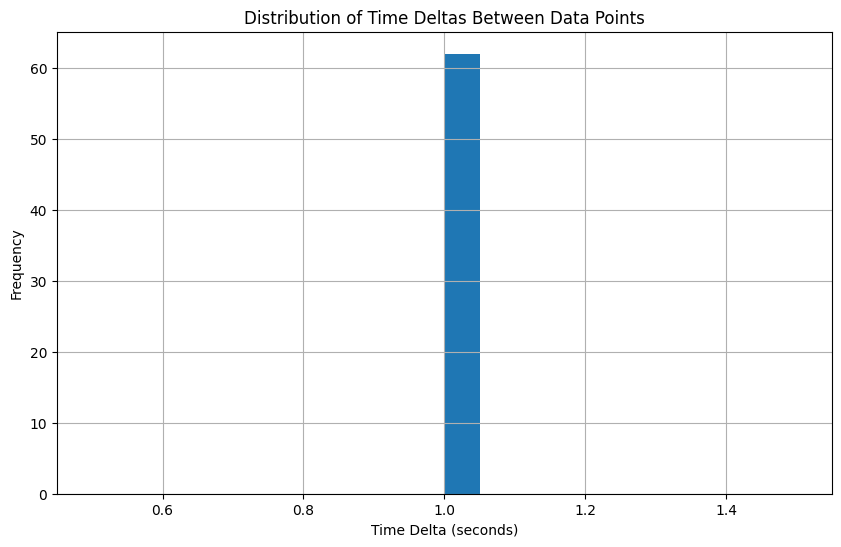

In [25]:
# Calculate time deltas between records
if not timestamp_comparison.empty and len(timestamp_comparison) > 1:
    # Calculate differences between consecutive timestamps
    unix_timestamps = timestamp_comparison['Unix Timestamp (parsed)'].values
    time_deltas = [unix_timestamps[i+1] - unix_timestamps[i] for i in range(len(unix_timestamps)-1)]
    
    # Create a DataFrame for the deltas
    deltas_df = pd.DataFrame({
        'Time Delta (seconds)': time_deltas
    })
    
    # Display summary statistics for the time deltas
    print("Time delta statistics (seconds between data points):")
    print(deltas_df['Time Delta (seconds)'].describe())
    
    # Create a histogram of the time deltas
    plt.figure(figsize=(10, 6))
    plt.hist(deltas_df['Time Delta (seconds)'], bins=20)
    plt.title('Distribution of Time Deltas Between Data Points')
    plt.xlabel('Time Delta (seconds)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

## Visualize Unix vs FIT Timestamps

Let's visualize the relationship between Unix and FIT timestamps.

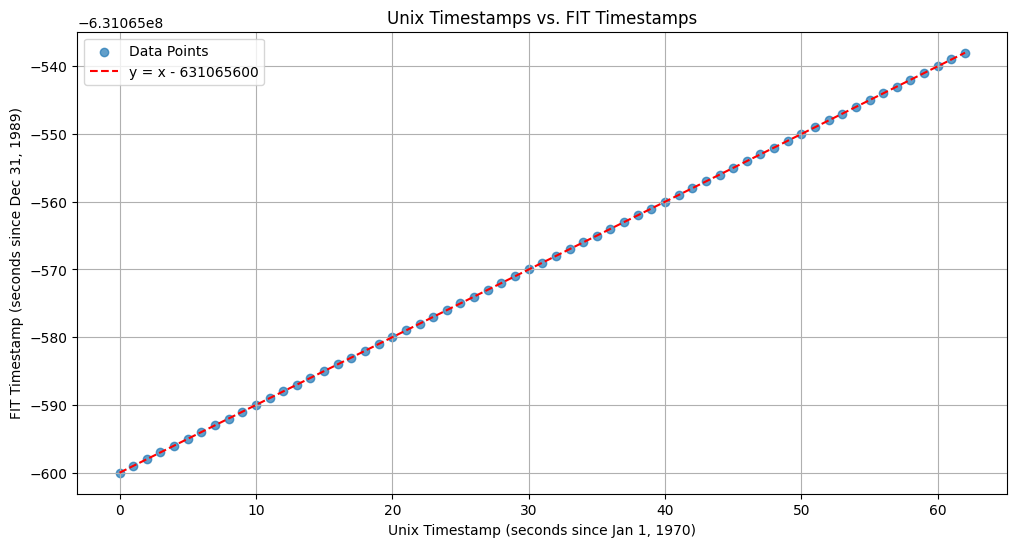

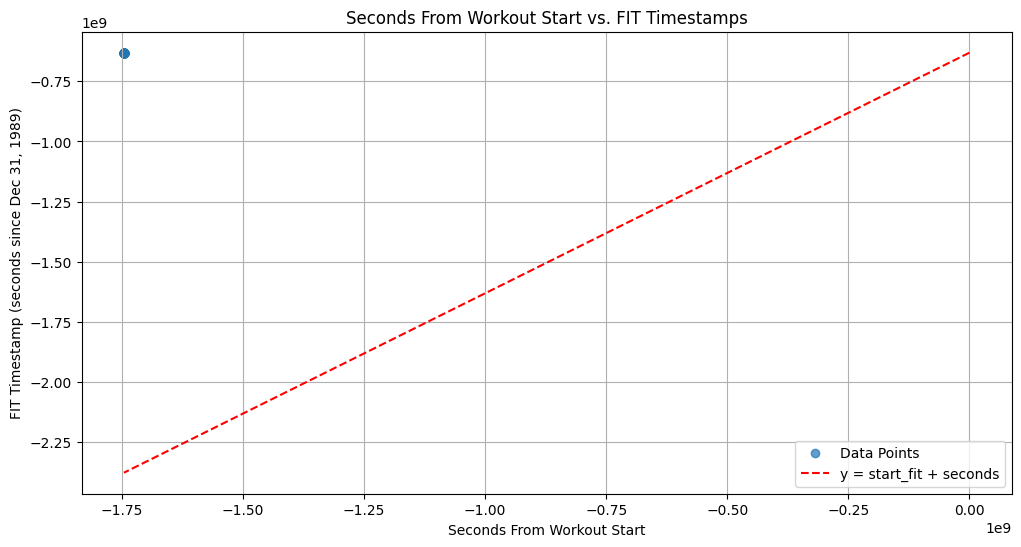

In [26]:
# Plot the relationship between Unix and FIT timestamps
if not timestamp_comparison.empty:
    plt.figure(figsize=(12, 6))
    
    # Plot Unix timestamps vs. FIT timestamps
    plt.scatter(
        timestamp_comparison['Unix Timestamp (parsed)'], 
        timestamp_comparison['FIT Timestamp'],
        alpha=0.7,
        label='Data Points'
    )
    
    # Add a line representing the theoretical conversion
    unix_min = timestamp_comparison['Unix Timestamp (parsed)'].min()
    unix_max = timestamp_comparison['Unix Timestamp (parsed)'].max()
    unix_range = [unix_min, unix_max]
    fit_range = [unix_to_fit_timestamp(unix_min), unix_to_fit_timestamp(unix_max)]
    
    plt.plot(unix_range, fit_range, 'r--', label=f'y = x - {FIT_EPOCH_SECONDS}')
    
    plt.title('Unix Timestamps vs. FIT Timestamps')
    plt.xlabel('Unix Timestamp (seconds since Jan 1, 1970)')
    plt.ylabel('FIT Timestamp (seconds since Dec 31, 1989)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Also plot time from start vs absolute value
    if 'Seconds From Start' in timestamp_comparison.columns:
        plt.figure(figsize=(12, 6))
        plt.scatter(
            timestamp_comparison['Seconds From Start'],
            timestamp_comparison['FIT Timestamp'],
            alpha=0.7,
            label='Data Points'
        )
        
        start_fit = timestamp_comparison['FIT Timestamp'].iloc[0]
        seconds_max = timestamp_comparison['Seconds From Start'].max()
        
        plt.plot([0, seconds_max], [start_fit, start_fit + seconds_max], 'r--', 
                 label=f'y = start_fit + seconds')
        
        plt.title('Seconds From Workout Start vs. FIT Timestamps')
        plt.xlabel('Seconds From Workout Start')
        plt.ylabel('FIT Timestamp (seconds since Dec 31, 1989)')
        plt.legend()
        plt.grid(True)
        plt.show()

## Summary

This notebook demonstrates the conversion between Unix timestamps and Garmin FIT timestamps for workout data. Key takeaways:

1. FIT timestamps are seconds since December 31, 1989 (while Unix timestamps are seconds since January 1, 1970)
2. The conversion between formats should be lossless when using integer timestamps
3. The FIT epoch is 631,065,600 seconds after the Unix epoch
4. When creating FIT files, proper timestamp handling is critical for Garmin compatibility

The timestamp conversion in your Rogue Garmin Bridge application correctly handles this conversion.

In [27]:
# Close the database connection
conn.close()
print("Database connection closed.")

Database connection closed.
